<font size="6" color="blue">Module 4 – Training Models</font>

<img src="images_module04/module04.png" width="600"/>


# Module Overview
***

Understanding what’s under the hood will help you debug issues and perform error analysis more efficiently. Additionally, most of the topics discussed here will be **essential in understanding, building, and training neural networks.** 

1. Linear Regression Training Approaches: 
    - **Closed-form equation**: directly computes the model parameters that best fit the model to the training set (minimize the cost function over the training set).
    - **Gradient Descent (GD):** iteratively tweak the model parameters to minimize the cost function, eventually converging to the same set of parameters as the first method.

2. Polynomial Regression: 
    - Fitting **nonlinear datasets** with linear models
    - Detect overfitting with learning curves 
    - Regularization techniques

3. Classification techniques
    - Logistic Regression
    - Softmax regression

**Learning Goal:** At the end of this module, you should understand the basics principles of model training, including gradient descent, overfitting vs underfitting, choosing the right optimization parameters, and much more! 


Helpful math resources:

- HOML Calculus: https://github.com/ageron/handson-ml2/blob/master/math_differential_calculus.ipynb
- HOML LinAlg: https://github.com/ageron/handson-ml2/blob/master/math_linear_algebra.ipynb
- Math for ML books: 
    - https://www.amazon.ca/Mathematics-Machine-Learning-Peter-Deisenroth/dp/110845514X/ref=asc_df_110845514X/?tag=googleshopc0c-20&linkCode=df0&hvadid=335213572220&hvpos=&hvnetw=g&hvrand=10650050461168788120&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9061009&hvtargid=pla-898490796899&psc=1
    - https://www.amazon.ca/Linear-Algebra-Optimization-Machine-Learning/dp/3030403467/ref=pd_sbs_sccl_3_4/144-3092094-1114406?pd_rd_w=jmGHD&content-id=amzn1.sym.6d44cef4-95d9-4421-b5e2-6074721e9da2&pf_rd_p=6d44cef4-95d9-4421-b5e2-6074721e9da2&pf_rd_r=2YW3PXRX4J82MTJACKXH&pd_rd_wg=FTTwn&pd_rd_r=6d5c09e3-53a7-4f91-a1f9-b29a5eed170d&pd_rd_i=3030403467&psc=1&asin=3030403432&revisionId=&format=4&depth=1
- Deep Learning Book: https://www.amazon.ca/Deep-Learning-Ian-Goodfellow/dp/0262035618/ref=pd_sbs_sccl_3_3/144-3092094-1114406?pd_rd_w=jmGHD&content-id=amzn1.sym.6d44cef4-95d9-4421-b5e2-6074721e9da2&pf_rd_p=6d44cef4-95d9-4421-b5e2-6074721e9da2&pf_rd_r=2YW3PXRX4J82MTJACKXH&pd_rd_wg=FTTwn&pd_rd_r=6d5c09e3-53a7-4f91-a1f9-b29a5eed170d&pd_rd_i=0262035618&psc=1


In [2]:
# Common imports
import numpy as np
import os
import tarfile
from six.moves import urllib
import pandas as pd
import sklearn

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

## Review

In Module 1 we looked at a simple regression model of life satisfaction: 
- life_satisfaction = θ1 + (θ2 × GDP_per_capita )

This model is just a **linear function of the input feature GDP_per_capita**. θ1 and θ2 are the model’s parameters. 

A linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the bias term (also called the intercept term):

<img src="images_module04/01_linreg.png" width=600/>

where:
- $\hat{y}$ is the predicted value
- $n$ is the number of features
- $x_i$ is the $i^{th}$ feature value
- $\theta_j$ is the $j^{th}$ model parameter (including the bias term $\theta_0)$


This can be written more succintly as:

<img src="images_module04/02_linreg2.png" width=600/>

where:
- $\mathbf{\theta}$ is the model's **parameter vector**, containing the bias term and all of the feature weights
- $\mathbf{x}$ is the model's **feature vector**, containing $x_0$ to $x_n$, where $x_0$ is always equal to 1
- $h_{\mathbf{\theta}}$ is the hypothesis function parameterized by vecotr $\mathbf{\theta}$ .




OK, that’s the Linear Regression model but how do we train it? 

Well, recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, **we first need a measure of how well (or poorly) the model fits the training data.** 
- In Module 2 we saw that the most common performance measure of a **regression model is the Root Mean Square Error (RMSE)**. 
- Therefore, to train a Linear Regression model, we need to **find the value of $\theta$ that minimizes the RMSE**. 
- In practice, it is **simpler to minimize the mean squared error (MSE) than the RMSE,** and it leads to the same result (because the value that minimizes a function also minimizes its square root). 

<img src="images_module04/03_mse.png" width=600/>







A couple quick comments on notation:
- In Machine Learning, vectors are often represented as column vectors, which are 2D arrays with a single column. 
- If $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors, then the prediction is $\hat{y}=\mathbf{\theta^T}\mathbf{x}$, where:
    - $\mathbf{\theta^T}$ is the transpose of $\mathbf{\theta}$ (a row vector instead of a column vector)
    - and $\mathbf{\theta^T}\mathbf{x}$ is the matrix multiplication of $\mathbf{\theta^T}$ and $\mathbf{x}$. 
- It is of course the same prediction, except that it is now represented as a **single-cell matrix rather than a scalar value**. 
- Also note that to simplify notations, we will often just write $MSE(\theta )$ instead of $MSE( \mathbf{X} , h_{\mathbf{\theta}} )$, but they mean the same thing.

In [3]:
theta = np.random.rand(10,1)
print(theta.shape)
theta

(10, 1)


array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864],
       [0.15599452],
       [0.05808361],
       [0.86617615],
       [0.60111501],
       [0.70807258]])

In [4]:
x = np.random.rand(10,1)
print(x.shape)
x

(10, 1)


array([[0.02058449],
       [0.96990985],
       [0.83244264],
       [0.21233911],
       [0.18182497],
       [0.18340451],
       [0.30424224],
       [0.52475643],
       [0.43194502],
       [0.29122914]])

In [5]:
# theta@x # Wont work! Shapes don't match
theta.T @ x

array([[2.66131965]])

## Normal Equation

To find the value of θ that minimizes the cost function, there is a **closed-form solution called the Normal Equation**:

<img src="images_module04/04_normalequation.png" width="600" />

where:
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function
- $y$ is the vector of target values 


In [6]:
import numpy as np

# Function: y = 4 + 3x + Gaussian Noise
theta1 = 4
theta2 = 3
m = 1000

X = 2 * np.random.rand(m, 1)
X_b = np.c_[np.ones((m, 1)), X]  # add x0 = 1 to each instance
y = theta1 + theta2 * X + np.random.randn(m, 1)
print(X_b.shape)
print(y.shape)

(1000, 2)
(1000, 1)


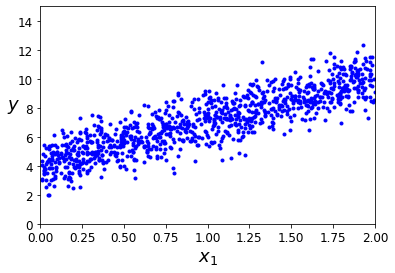

In [7]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# Use numpys linalg.inv function to calculate matrix inverse
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [9]:
theta_best

array([[4.10210272],
       [2.9917449 ]])

We would have hoped for `theta1 = 4` and `theta2 = 3`, but noise made it impossible to recover the exact parameters of the original function. 


In [10]:
# X.dot(X_inv) = identiy matrix
mtrx = X_b.T.dot(X_b)
np.linalg.inv(mtrx).dot(mtrx)

array([[ 1.0000000e+00,  4.4408921e-16],
       [-4.4408921e-16,  1.0000000e+00]])

In [11]:
# Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
X_new_b

array([[1., 0.],
       [1., 2.]])

In [12]:
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.10210272],
       [10.08559252]])

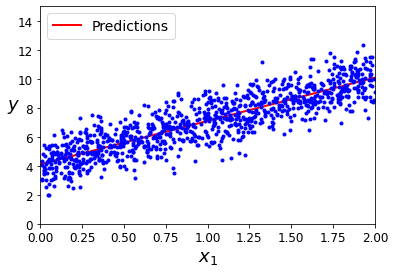

In [13]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("THETA:", lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)


THETA: [4.10210272] [[2.9917449]]


array([[ 4.10210272],
       [10.08559252]])

In [15]:
pd.DataFrame({"NormEq":[i[0] for i in theta_best],
              "LinReg":[lin_reg.intercept_[0], lin_reg.coef_[0][0]],
              "Actual":[4,3]
             })

,NormEq,LinReg,Actual
0,4.102103,4.102103,4
1,2.991745,2.991745,3


The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [16]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.10210272],
       [2.9917449 ]])

This function computes $\theta=\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly.

In [17]:
np.linalg.pinv(X_b).dot(y)

array([[4.10210272],
       [2.9917449 ]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **Singular Value Decomposition (SVD)** that can decompose any $m \times n$ matrix $M$ into the matrix multiplication of three matrices $U \cdot \Sigma \cdot V^{T}$ (see numpy.linalg.svd()):

* a rotation matrix $U$ (an $m \times m$ orthogonal matrix)
* a scaling & projecting matrix $\Sigma$ (an $m \times n$ diagonal matrix)
* and another rotation matrix $V^T$ (an $n \times n$ orthogonal matrix)

$M = U \cdot \Sigma \cdot V^{T}$

The pseudoinverse is computed as $\mathbf{X}^+ = \mathbf{V} \mathbf{\Sigma}^+ V^{T}$. 

To compute the matrix $\mathbf{\Sigma}^+$, the algorithm takes Σ and sets to zero all values smaller than a tiny threshold value, then it replaces all the nonzero values with their inverse, and finally it transposes the resulting matrix. 

This approach is **more efficient than computing the Normal Equation, plus it handles edge cases nicely:** 
- the Normal Equation may not work if the matrix X ⊺ X is not invertible (i.e., singular), such as if m < n or if some features are redundant, but the pseudoinverse is always defined. 



## Computational Complexity 

The Normal Equation computes the inverse of X ⊺ X , which is an (n+1) × (n+1) matrix (where n is the number of features). 

The computational complexity of inverting such a matrix is typically about **O(n^2.4) to O(n^3)**:
- if you **double the number of features, you multiply the computation time by roughly 2^2.4 = 5.3 to 2^3 = 8**. 

The SVD approach used by Scikit-Learn’s `LinearRegression` class is about O(n^2). If you double the number of features, you multiply the computation time by roughly 4. 

**NOTE**: Both the **Normal Equation and the SVD approach get very slow when the number of features grows large (e.g., 100,000)**. 
- But both are **linear with regard to the number of instances in the training set (they are O(m))**

running for 10 feats
running for 20 feats
running for 40 feats
running for 80 feats
running for 160 feats
running for 320 feats
running for 640 feats
running for 1280 feats
running for 2560 feats


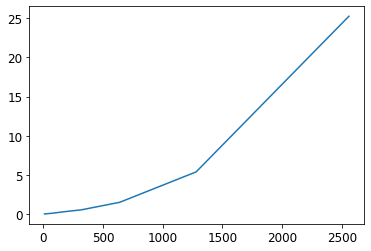

In [18]:
from time import time
run = True

if run:
    feats = [10, 20, 40, 80, 160, 320, 640, 1280, 2560] #, 5120]

    rt_svd = []
    for i in feats:
        print("running for {} feats".format(i))
        x = np.random.rand(8000,i)    
        t0 = time()
        _ = np.linalg.pinv(x)
        rt_svd.append(time()-t0)
    plt.plot(feats, rt_svd)

Once you have trained a linear regression model, regardless of the method, prediction is pretty much always the exact same.

The computational complexity is linear with regards to both number of instances and number of features. So making twice as many predictions will take twice as long.

# Linear regression using Gradient descent

## Basic Overview

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. **The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function (over the training set).** 

Suppose you are lost in the mountains in a dense fog:
- You can only feel the slope of the ground below your feet.
- To get to the bottom of the valley quickly, go downhill in the direction of the **steepest slope**. 

This is exactly what Gradient Descent does! It measures:
 - the **local gradient (slope or tangent line) of the error function with regard to the parameter vector θ**, and it goes in the direction of descending gradient. 
 - Once the gradient is zero, you have reached a minimum! 

More concretely:
1. Start by filling θ with random values (random initialization). 
2. Take one small gredient descent step at a time, each step attempting to decrease the cost function (e.g., the MSE). 
    - If you have the gradient vector which points uphill, just go in the opposite direction to go downhill. 
3. Stop when the algorithm **converges to a minimum**. 


**The learning step size is proportional to the slope of the cost function, so the steps gradually get smaller as the parameters approach the global minimum:** 

<img src="images_module04/05_gd1.png" width="600" />

## Calculating Gradients

To implement Gradient Descent, you need to **compute the gradient of the cost function with regard to each model parameter θj**. 

In other words, you need to calculate how much the cost function will change if you change θj just a little bit. **This is called a partial derivative**. 
 
Equation below computes the **partial derivative** of the cost function with regard to parameter θj:

<img src="images_module04/03_mse.png" width=600/>

<img src="images_module04/06_msederivative1.png" width=600/>


The vectorized form of the equation (calculating all gradients at once, the gradient vector) is below:

<img src="images_module04/07_msederivative2.png" width=600/>



We can implement this in code as follows:

In [19]:
# Redfine function: y = 4 + 3x + Gaussian Noise
theta1 = 4
theta2 = 3
m = 1000

X = 2 * np.random.rand(m, 1)
X_b = np.c_[np.ones((m, 1)), X]  # add x0 = 1 to each instance
y = theta1 + theta2 * X + np.random.randn(m, 1)
print(X_b.shape)
print(y.shape)

(1000, 2)
(1000, 1)


In [20]:
# random initialization
theta = np.random.randn(2,1)  
gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)

# Slope of cost function at theta
gradients

array([[-13.83368172],
       [-15.65981717]])

In [21]:
theta_best_svd

array([[4.10210272],
       [2.9917449 ]])

In [22]:
# Using best theta, what do you think gradients will be?
gradients = 2/m * X_b.T.dot(X_b.dot(theta_best_svd) - y)

# Slope of cost function at theta
# gradients

## Learning rates

We use a **learning rate η** to determine the size of the gradient descent step: 
- multiply the gradient vector by η to determine the size of the downhill step 

<img src="images_module04/08_gdstep.png" width="600">


<font color="red">The learning rate (the size of the steps) is an extremely important hyperparameter.</font> 
- too small, and the algorithm will have to go through many iterations to converge,
- too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. 

<img src="images_module04/09_lr1.png" width="800" />

In [23]:
from sklearn.metrics import mean_squared_error

def gs_batch(X, y, eta=0.00001, n_epochs=200):
    theta = np.random.randn(2,1)  # random initialization
    thetas = []
    g_bias = []
    g_theta = []
    mses = []
    m = X.shape[0]
    for epoch in range(n_epochs):
        # Gradient Descent Steps
        gradients = 2/m * X.T.dot(X.dot(theta) - y) # Calc derivatives
        theta = theta - eta * gradients # Update step
        # Store resultls
        y_hat = X.dot(theta) # Make Preds
        mse = mean_squared_error(y, y_hat)
        thetas.append(theta)
        g_bias.append(gradients[0][0])
        g_theta.append(gradients[1][0])
        mses.append(mse)
        thetas.append(theta)
    print(f"Training Complete! Ran for {epoch+1} iterations")
    return theta, thetas, g_bias, g_theta, mses  

In [24]:
def plot_gs(gradients, mses, figsize=(15,7)):
    n_iterations = len(gradients)
    fig, ax1 = plt.subplots(figsize=figsize)
    color = 'tab:red'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Gradient', color=color)
    ax1.plot(range(n_iterations), gradients, color=color)
    ax1.set_ylim(max(gradients), min(gradients)-1)
    ax1.tick_params(axis='y', labelcolor=color)
    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Cost (MSE)', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(n_iterations), mses, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Training Complete! Ran for 200 iterations


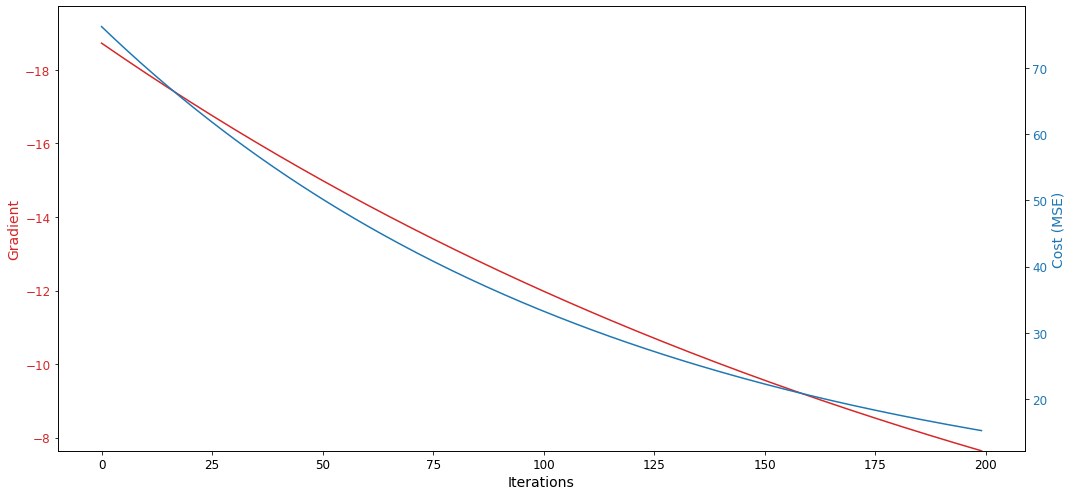

THETA:
 [[0.2917389 ]
 [2.91735404]]


In [25]:
# Run Function
theta, thetas_batch, g_bias, g_theta, mses = gs_batch(X_b, y, eta=0.001, n_epochs=200)
# Plot results
plot_gs(g_theta, mses)
# plot_gs(g_bias, mses)
print("THETA:\n", theta)


Training Complete! Ran for 200 iterations


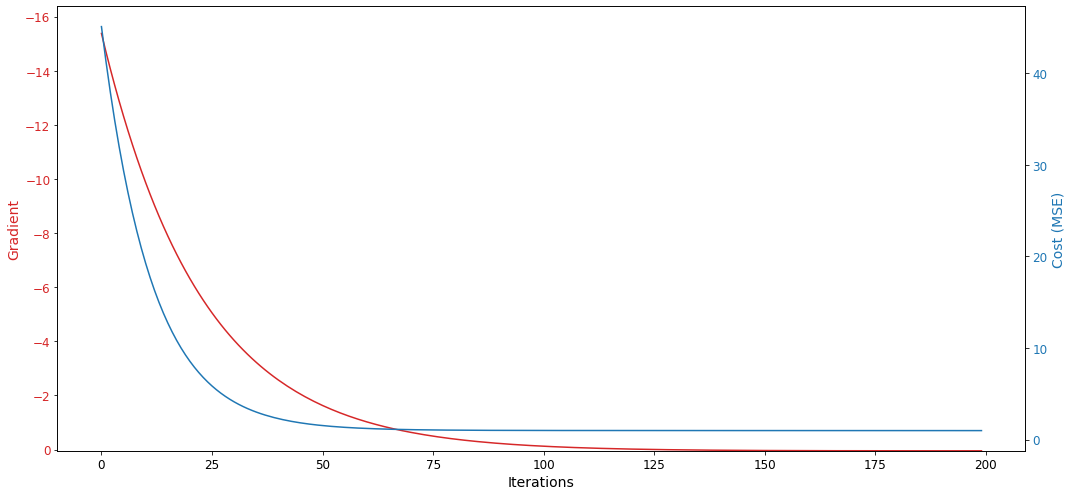

THETA:
 [[3.73226567]
 [3.22727167]]


In [26]:
# Run Function
theta, thetas_batch, g_bias, g_theta, mses = gs_batch(X_b, y, eta=0.01, n_epochs=200)
# Plot results
plot_gs(g_theta, mses)
# plot_gs(g_bias, mses)
print("THETA:\n", theta)


In [27]:
pd.DataFrame({"NormEq":[i[0] for i in theta_best],
              "LinReg":[lin_reg.intercept_[0], lin_reg.coef_[0][0]],
              "BGD": [i[0] for i in thetas_batch[-1]],
              "Actual":[4,3]
             })

,NormEq,LinReg,BGD,Actual
0,4.102103,4.102103,3.732266,4
1,2.991745,2.991745,3.227272,3


In [28]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

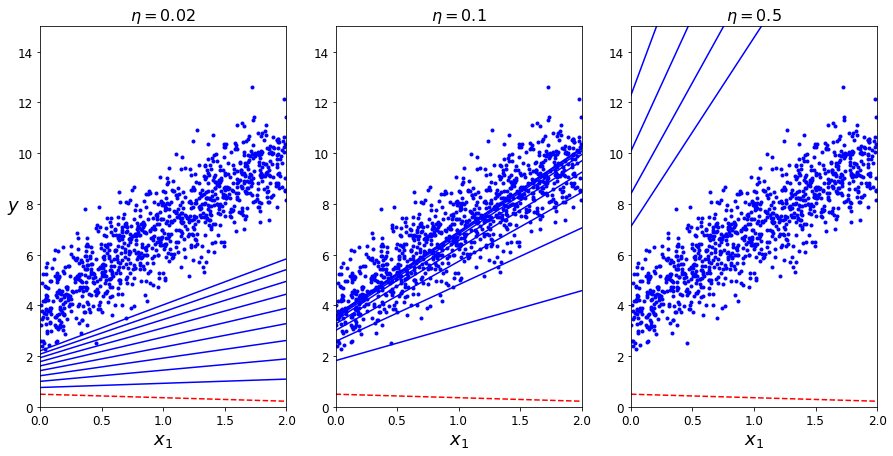

In [29]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(15,7))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## Choosing the number of iterations (gradient descent steps):
- Set learning rate to a reasonable number (0.01)
- Set a very large number of iterations
- Interrupt the algorithm when the gradient vector becomes tiny (its norm becomes smaller than a tiny number ϵ (called the tolerance). 
    - OR when the loss stops decreasing

In [30]:
from sklearn.linear_model import SGDRegressor
# ?SGDRegressor

## Convex vs Non Convex Cost Functions
Not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, **making convergence to the minimum difficult.** These are called **non-convex functions**.

<img src="images_module04/10_nonconvex.png" width="600" />

Gradient descent is performing a **search in the model’s parameter space**: 
- the more parameters a model has, the more dimensions this space has, and the harder the search is
- Neural nets with thousands of parameters, for example, are complicated non-convex functions

The MSE cost function for a Linear Regression model happens to be a convex function, which means that if you pick **any two points on the curve, the line segment joining them never crosses the curve.** 
- There are no local minima, **just one global minimum.**
- It is a **continuous function** with a slope that never changes abruptly. 
- Gradient Descent is **guaranteed to approach arbitrarily close the global minimum** (if learning rate is not too high). 

Even with convex functions however, you can run into the **elongated bowl problem** if the features have very different scales. Below is an example of a linear regression gradient descent performed on data with similar and not-so-similar scales: 

<img src="images_module04/11_elongbowl.png" width="600" />

- On the left the Gradient Descent algorithm goes straight toward the minimum
- On the right it first goes in a direction almost orthogonal to the direction of the global minimum, but eventually reaches the minimum. 

**When using Gradient Descent, ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.**



## Stochastic Gradient Descent (SGD)

Above we calculated the gradient over the entire training set, which is why its called **batch gradient descent** (we used the entire batch). This technique can be very slow when the training set is large. 

Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients **based only on that single instance.** 
- Runs very quickly 
- Good for huge training sets **(out-of-core algorithm)**
- When the cost function irregular (non-convex), **the randomness of SGD can actually help the algorithm jump out of local minima.** 

However SGD is much less regular than Batch Gradient Descent: 
- The cost function will bounce up and down, **decreasing only on average**. 
- Will end up very close to the minimum, but will continue to bounce around, never settling down. 

<img src="images_module04/12_sgd.png" width="600"/>

**NOTE:** When using SGD, training instances must be **independent and identically distributed (IID)**. This will ensure that the parameters get pulled toward the global optimum, **on average.** 


## Learrning Rate Scheules
One solution to dealing with SGD's bouncing around global minimum is to **gradually reduce the learning rate**:
- The steps start out large (which helps make quick progress and escape local minima)
- Gradually reduce the steps based on defined schedule (learning rate schedule)

We iterate by **rounds of m iterations**; each round is called an **epoch**. 

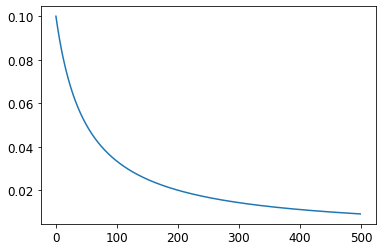

In [31]:
def learning_schedule(t, t0=5, t1=50):
    return t0 / (t + t1)

lrs = [learning_schedule(i) for i in range(500)]
plt.plot(range(500), lrs)
plt.show()
        

In [32]:
def gs_stochastic(X, y, eta=0.01, use_lrs=True, n_epochs=100, max_iter=2000):
    theta = np.random.randn(2,1)  # random initialization
    thetas = []
    g_bias = []
    g_theta = []
    mses = []
    m = X.shape[0]
    t=0
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  # Calc derivatives
            if use_lrs:
                eta = learning_schedule(t) # Calc lr
            theta = theta - (eta * gradients) # Update step
            y_hat = X.dot(theta) # Make Preds
            mse = mean_squared_error(y, y_hat)
            # Append values
            thetas.append(theta)
            g_bias.append(gradients[0][0])
            g_theta.append(gradients[1][0])
            mses.append(mse)
            thetas.append(theta)
            t += 1 # Normally this would be done on every epoch, not iteration
            if len(g_bias)==max_iter:
                print(f"Training Complete! Ran for {t} iterations")
                return theta, thetas, g_bias, g_theta, mses                  
    print(f"Training Complete! Ran for {t-1} iterations")
    return theta, thetas, g_bias, g_theta, mses  

Training Complete! Ran for 2000 iterations


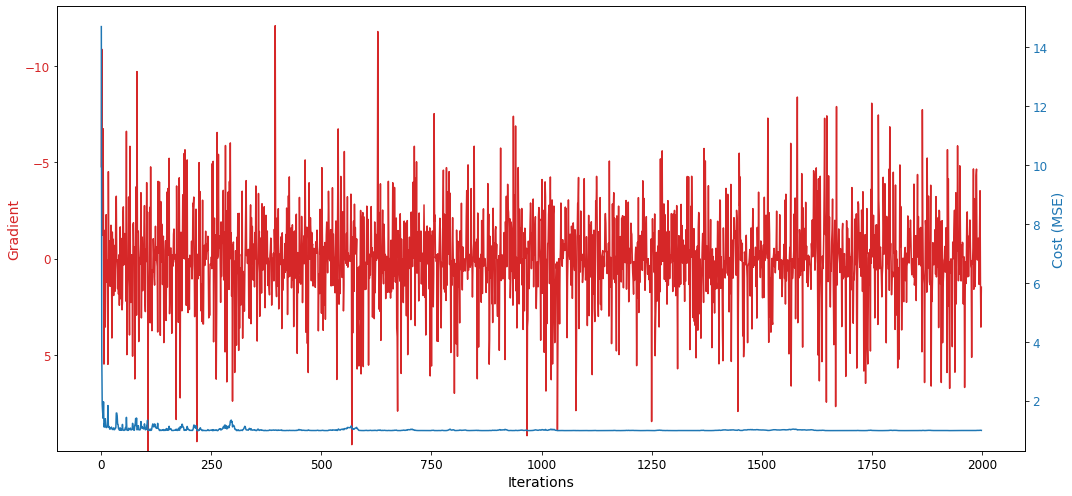

THETA:
 [[3.98227694]
 [3.08852749]]


In [33]:
# Run Function
theta, thetas_sgd, g_bias, g_theta, mses = gs_stochastic(X_b, y, eta=0.001, use_lrs=True)
# Plot results
plot_gs(g_theta, mses)
print("THETA:\n", theta)


In [34]:
pd.DataFrame({"NormEq":[i[0] for i in theta_best],
              "LinReg":[lin_reg.intercept_[0], lin_reg.coef_[0][0]],
              "BGD": [i[0] for i in thetas_batch[-1]],
              "SGD": [i[0] for i in thetas_sgd[-1]],
              "Actual":[4,3]
             })

,NormEq,LinReg,BGD,SGD,Actual
0,4.102103,4.102103,3.732266,3.982277,4
1,2.991745,2.991745,3.227272,3.088527,3


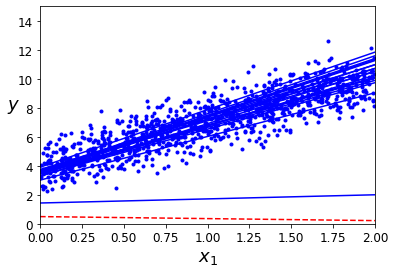

In [35]:
np.random.seed(42)

m = len(X_b)
n_epochs = 5
theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

Let's run the same model with `SGDRegressor`. 

Look at the documentation to understand the arguments!

In [36]:
# ?SGDRegressor

In [37]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [38]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.96370834]), array([3.13011684]))

## Mini-batch gradient descent

Mini-batch GD computes the gradients on **small random sets of instances called mini-batches.** This method can result in:
- Performance boosts (espeically when training on GPUs)
- Less eratic reduction in loss (especially as you increase mini-batch size)

However, it might have more trouble escaping local minima as compared to SGD:




In [39]:
def gs_minibatch(X, y, eta=0.01, use_lrs=True, n_epochs=20,  max_iter=200, minibatch_size=10):
    theta = np.random.randn(2,1)  # random initialization
    thetas = []
    g_bias = []
    g_theta = []
    mses = []
    m = X.shape[0]
    t=0
    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, minibatch_size):
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
            if use_lrs:
                eta = learning_schedule(t) # Calc lr
            theta = theta - eta * gradients # Update step
            y_hat = X.dot(theta) # Make Preds
            mse = mean_squared_error(y, y_hat)
            # Append values
            thetas.append(theta)
            g_bias.append(gradients[0][0])
            g_theta.append(gradients[1][0])
            mses.append(mse)
            thetas.append(theta)
            t += 1 # Normally this would be done on every epoch, not iteration
            if len(g_bias)==max_iter:
                print(f"Training Complete! Ran for {t} iterations")
                return theta, thetas, g_bias, g_theta, mses                  
    print(f"Training Complete! Ran for {t-1} iterations")
    return theta, thetas, g_bias, g_theta, mses  

Training Complete! Ran for 200 iterations


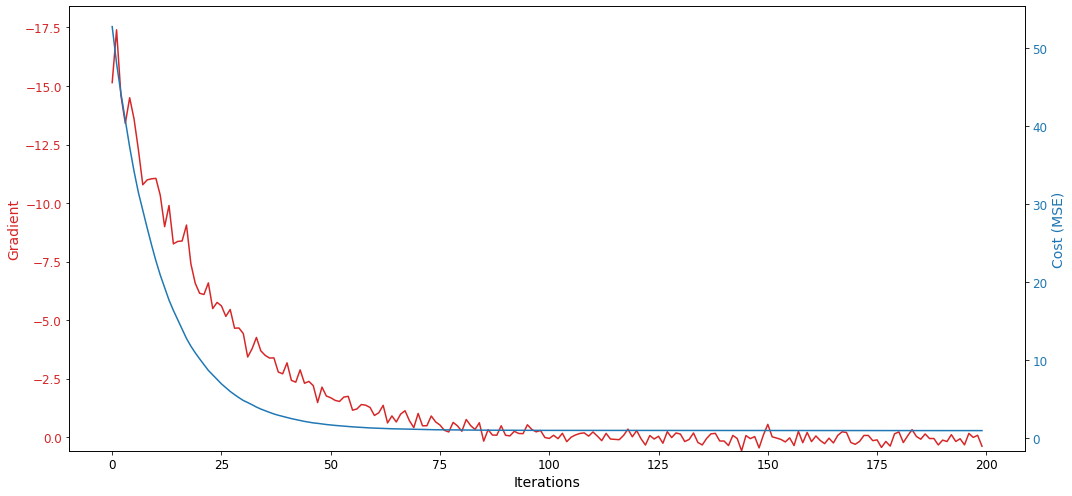

THETA:
 [[3.61978717]
 [3.32412291]]


In [40]:
# Run Function
theta, thetas_mb, g_bias, g_theta, mses = gs_minibatch(X_b, y, use_lrs=False, minibatch_size=128, n_epochs=50)
# Plot results
plot_gs(g_theta, mses)
print("THETA:\n", theta)


In [41]:
pd.DataFrame({"NormEq":[i[0] for i in theta_best],
              "LinReg":[lin_reg.intercept_[0], lin_reg.coef_[0][0]],
              "BGD": [i[0] for i in thetas_batch[-1]],
              "SGD": [i[0] for i in thetas_sgd[-1]],
              "MGD": [i[0] for i in thetas_mb[-1]],
              "Actual":[4,3]
             })

,NormEq,LinReg,BGD,SGD,MGD,Actual
0,4.102103,4.102103,3.732266,3.982277,3.619787,4
1,2.991745,2.991745,3.227272,3.088527,3.324123,3


Training Complete! Ran for 300 iterations
Training Complete! Ran for 300 iterations
Training Complete! Ran for 300 iterations


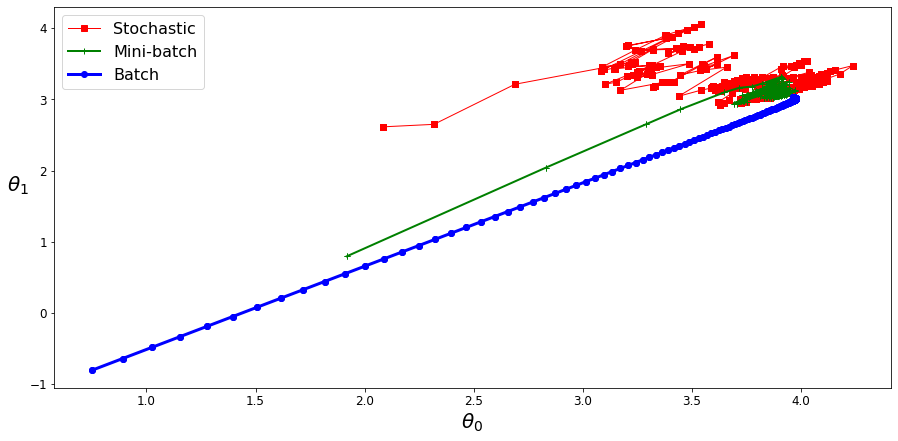

In [42]:
lr = 0.01
max_iter = 300

theta, thetas_bgd, g_bias, g_theta, mses = gs_batch(X_b, y, eta=lr, n_epochs=max_iter)
theta, thetas_sgd, g_bias, g_theta, mses = gs_stochastic(X_b, y, eta=lr, max_iter=max_iter)
theta, thetas_mgd, g_bias, g_theta, mses = gs_minibatch(X_b, y, eta=lr, max_iter=max_iter, minibatch_size=10)

theta_path_bgd = np.array(thetas_bgd)
theta_path_sgd = np.array(thetas_sgd)
theta_path_mgd = np.array(thetas_mgd)

plt.figure(figsize=(15,7))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
# plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

Here are some of the tradeoffs with the methods we have discussed so far:

<img src="images_module04/14_linreggd.png" width="800" />

# Polynomial regression

You can use a simple linear algorithm to model more complex non-linear data with the help of **polynomial features**:
- Add powers of each features as new features
- Include interaction terms
- Train new model!

Let’s generate some nonlinear data, based on a simple quadratic equation (plus noise):

In [43]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [44]:
import numpy as np

# Function: y = 2 + 0.2x + 0.5(x^2) + Gaussian Noise
intercept = 2
theta1 = 0.2
theta2 = 0.5
m = 100

X = 6 * np.random.rand(m, 1) - 3
y = (theta1 * X) + (theta2 * X**2) + intercept + np.random.randn(m, 1)
print(X.shape)
print(y.shape)

(100, 1)
(100, 1)


In [45]:
# m = 100
# X = 6 * np.random.rand(m, 1) - 3
# y = 0.5 * X**2 + 0.1 * X + 2 + np.random.randn(m, 1)

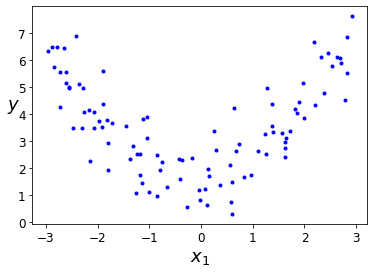

In [46]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X[0]**2, X[0]**3, X[0]**4)
X_poly[0]

[-0.75275929] [0.56664654] [-0.42654845] [0.32108831]


array([-0.75275929,  0.56664654, -0.42654845,  0.32108831])

In [48]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X[0]**2)
X_poly[0]

[-0.75275929] [0.56664654]


array([-0.75275929,  0.56664654])

When there are multiple features, Polynomial Regression is capable of finding relationships **between features**. 

This is made possible by the fact that PolynomialFeatures also adds all **combinations of features up to the given degree**. 

For example, if there were two features a and b, PolynomialFeatures with degree=3 would give you:
- power terms: `a**2`, `a**3`, `b**2`, and `b**3`,
- interaciton terms: `ab` , `a**2b` , and `ab**2`. 


`PolynomialFeatures(degree=d)` transforms an array containing *n* features into an array containing `(n+d)!/d!n!` features.

In [49]:
# ?PolynomialFeatures

In [50]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.13366893, 0.56456263]]))

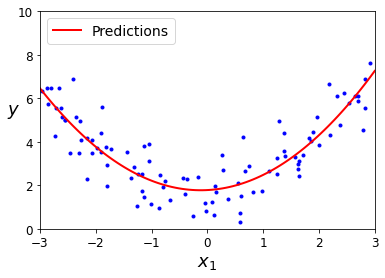

In [51]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

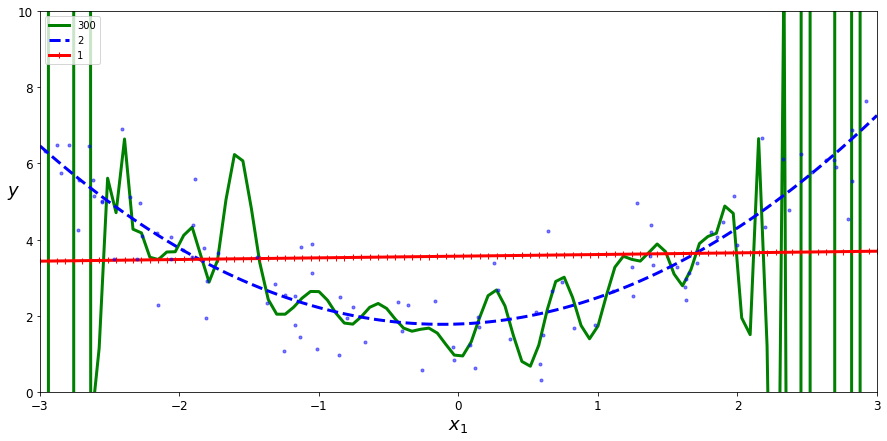

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(15,7))
for style, width, degree in (("g-", 3, 300), ("b--", 3, 2), ("r-+", 3, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3, alpha=0.5)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

This high-degree Polynomial Regression model is **severely overfitting** the training data, while the linear model is **underfitting it**. 

The model that will generalize best in this case is the **quadratic model**, which makes sense because the data was generated using a quadratic model. 

# Learning Curves

How can you tell that your model is overfitting or underfitting the data? 

Cross-validation is one approach to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting.

Another way to tell is to look at the learning curves, which **plot of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration).** 

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

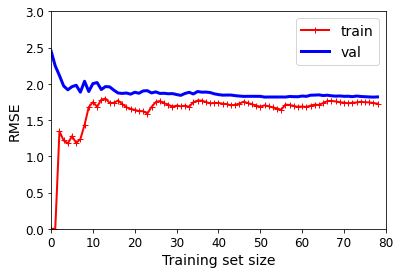

In [54]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

This model is **underfitting** (close and high):
- Training Data Curve:
    - When there are just one or two instances in the training set, the model can fit them perfectly
    - As new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly
    - The error reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse.
- Validation Data Cruve:
    - With very few training instances, it is incapable of generalizing properly 
    - As the model is shown more training examples, it learns, and thus the validation error slowly goes down (but only to plateau)

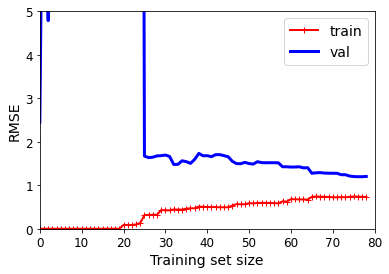

In [55]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=20, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 5])           # not shown
plt.show()                        # not shown

This model is **overfitting** (low train, high val):

There are two very important differences to previous curves: 
- The error on the *training data* is much lower than with the Linear Regression model.
- There is a gap between the curves, which means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. 

**If you used a much larger training set, however, the two curves would continue to get closer.**

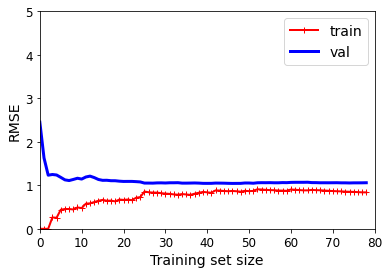

In [56]:
# intercept = 2
# theta1 = 0.2
# theta2 = 0.5
# m = 1000

# X = 6 * np.random.rand(m, 1) - 3
# y = (theta1 * X) + (theta2 * X**2) + intercept + np.random.randn(m, 1)
# print(X.shape)
# print(y.shape)

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 5])           
plt.show()                        

**Note**: For models that are more expensive or time-consuming to train, sometimes learning curves are plotted as a function of training epoch, instead of training set size. The interpretation is exactly the same. Also note that these curves might look slightly different depending on the ML problem (regression vs classification) and whether we are viewing the value of the cost function or the performance metric. 

For instance, below we see learning curves that were plotted for a multi-class image classification problem. The accuracy is poor to begin with, but you can see its improvement with additional passess over the training data. This is a bit different from regression problems, where typically the performance will look good when iterations are low, and then grow worse before growing better. 

<img src="images_module04/learning_curve_vs_epoch.png" width="600"/>

# The Bias/Variance Trade-off 

A model’s **generalization error** can be expressed as the sum of three very different errors: 

<img src="images_module04/bias_variance_eqn.png" width=900/>


- Bias: 
    - Due to wrong assumptions about data, such as assuming that the data is linear when it is actually quadratic. 
    - A high-bias model is most likely to **underfit** the training data
- Variance:
    - Due to model’s excessive sensitivity to small variations in the training data. 
    - A model with many degrees of freedom (a high-degree polynomial model) is likely to have high variance and thus **overfit** the training data. 
- Irreducible Error:
    - Due to the noisiness of the data itself. 
    - Only way to reduce this is to clean up the data.
    
  
Visualizing the effect of bias and variance on model performance:

<img src="images_module04/bias_variance_illustration.png" width=500/>

**Increasing a model’s complexity will typically increase its variance and reduce its bias (and vice versa).** There is typically an optimal level of complexity where the combined error is minimized. We can tune model complexity using a technique called **regularization**. 

<img src="images_module04/bias_variance_total_error.png" width=500/>

_Note: the above two plots were taken from [this source](http://scott.fortmann-roe.com/docs/BiasVariance.html)_. 

# Regularized models

A good way to reduce overfitting is to **regularize the model**: the fewer degrees of freedom a model has, the harder it will be for it to overfit the data (for instance, reduce number of polynomial degrees).

For a linear model, regularization is typically achieved by **constraining the weights of the model.** We will look at three of the main techniques:
- Ridge Regression, 
- Lasso Regression, 
- and Elastic Net.

## Ridge Regression (L2 Regularization)

Ridge Regression is a regularized version of Linear Regression: A regularization term is added to the cost function, forcing the learning algorithm to not only fit the data, but also constrain the weights. 


<img src="images_module04/15_ridge.png" width="600" />

- Note that the bias term is not regularized. 
- The regularization term is equal to $\frac{1}{2}(\|{w}\|_2)^2$, where $\|{w}\|_2$ represents the ℓ2 norm of the weight vector (excluding bias). 

The **hyperparameter α** controls how much you want to regularize the model:
- If α = 0, then Ridge Regression is just Linear Regression. 
- If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

For Gradient Descent, just add $αw$ to the MSE gradient vector:
- The ℓ2 gradient is linearly decreasing towards 0 as the weight goes towards 0 (the gradients decrease as the weights decrease). This can help converge and will reduce cost from bouncing around. **L2-regularization will move any weight towards 0, but it will take smaller and smaller steps as a weight approaches 0.**


> **❗️⚠️ NOTE**: The regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance. 


(100, 1)
(100, 1)


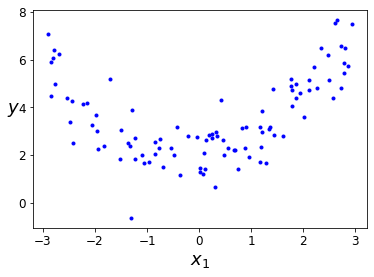

In [57]:
import numpy as np

intercept = 2
theta1 = 0.2
theta2 = 0.5
m = 100

X = 6 * np.random.rand(m, 1) - 3
y = (theta1 * X) + (theta2 * X**2) + intercept + np.random.randn(m, 1)
print(X.shape)
print(y.shape)


plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

In [58]:
from sklearn.linear_model import Ridge
# ?Ridge

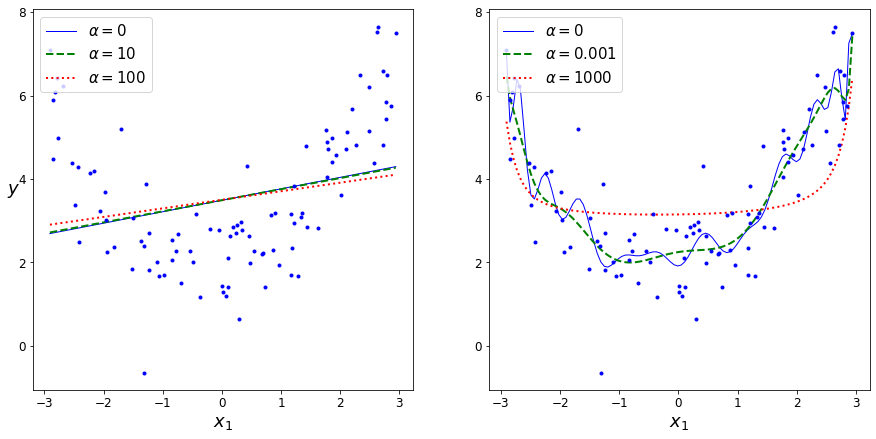

In [59]:
X_new=np.linspace(X.min(), X.max(), 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=25, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
#     plt.axis([0, 3, 0, 4])

plt.figure(figsize=(15,7))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 0.001, 1000), random_state=42)

plt.show()

Looking at the plot on the right, you see that as we increase the value of $\alpha$, we get a smoother curve, i.e. the fit becomes less sensitive. $\alpha=0.001$ seems like a pretty good value. Going too high (e.g. $\alpha=1000$ can start to introduce bias. Like any hyperparameter, you will have to experiment with $\alpha$ to find the best one.

Looking at the plot on the left, you can see the effect of L2 regularization on the weights. Here, we just have a simple straight line, $y = \theta_0 + \theta_1 x_1$, and we see that the slope with respect to $x_1$ decreases as we increase $\alpha$, which is just L2 doing its job (i.e. decreasing the magnitude of our weights). 

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation, an approximation (e.g. SVD), or by performing Gradient Descent. The pros and cons are the same as before.

<img src="images_module04/16_ridge.png" width="600" />


In [60]:
# Used closed form  (Cholesky matrix factorization)
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[3.89926445]])

In [61]:
# Use stochastic average gradient descent
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[3.89911451]])

Generally speaking, most scikit-learn models will have a built in 'penalty' parameter where you can specify that you want to use "l2" regularization, as per below. 

In [62]:
# Use SGDRegressor with L2 penalty
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([3.87500882])

## Lasso Regression (L1 Regularization)

Least Absolute Shrinkage and Selection Operator Regression **(Lasso Regression)** adds the ℓ1 norm of the weight vector instead of half the square of the ℓ2 nor.m 

<img src="images_module04/17_lasso.png" width="600"/>

In [63]:
from sklearn.linear_model import Lasso
# ?Lasso

/home/nnamdi/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.914245787062, tolerance: 0.029304832066504482
  positive)


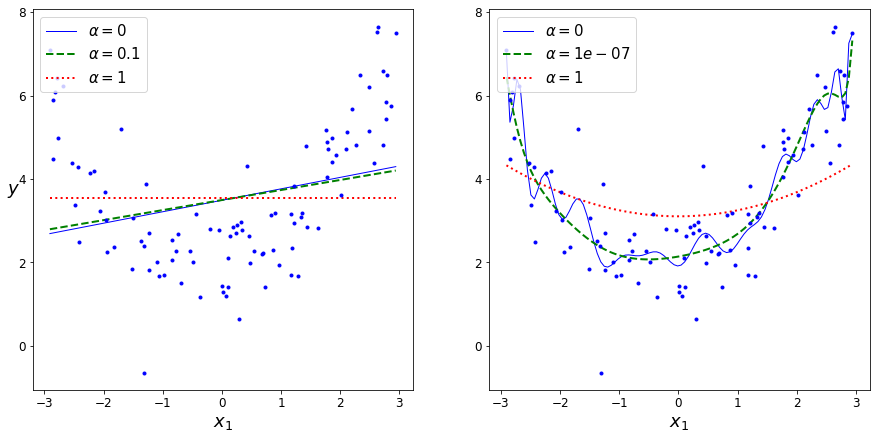

In [64]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42, tol=0.0001)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42, tol=0.0001)
plt.show()

In the rightmost plot, you see as before that increasing $\alpha$ decreases the variance. If you take a look at the plot on the left, you'll notice that with large enough $\alpha$, the model has eliminated its dependence on $x_1$ by setting $\theta_0 =0$. 

Lasso Regression tends to **eliminate the weights of the least important features** (i.e., set them to zero). In other words, Lasso Regression **automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).**

Why is this? Let's compare the **gradient contribution** between L1 and L2, for randomly initialized weights. 


Here is the subgradient vector **g** that is for Lasso regression:

<img src="images_module04/18_lasso.png" width="600"/>
See stackexchange post for more details: https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models


In [65]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([3.85540313])

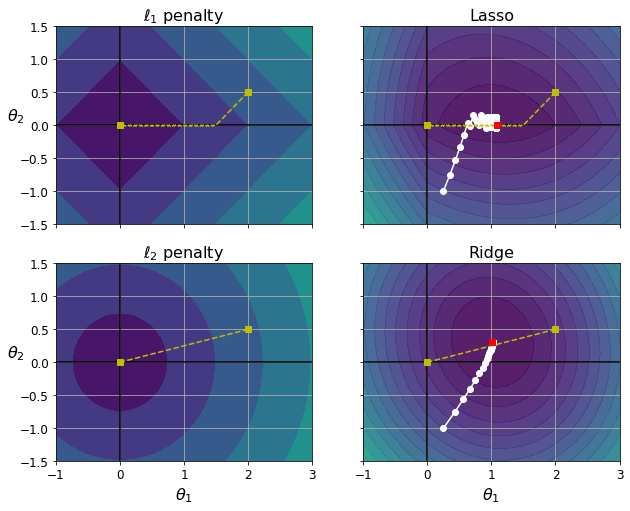

In [66]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

Note that there is a drawback to L1 regularization. 

For ℓ1 regularization, the gradient is either **1 or -1**, except for when 𝑤=0 (here the lasso cost function is not differentiable). That means that L1-regularization will move any weight towards 0 with the same step size, regardless the weight's value. 

This can cause gradient descent to bounce around the optimum, which we see in the plot above. Thus, when using Lasso you need to gradually reduce the learning rate during training (it will still bounce around the optimum, but the steps will get smaller and smaller, so it will converge). 

## Elastic Net

Elastic Net mixes both Ridge and Lasso’s regularization terms, and you can control the mix ratio with the hyparameter *r*. 

When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression.

<img src="images_module04/19_elasticnet.png" width="600" />

In [67]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([3.87224028])

**Which regularization technique should I use?**

It is almost always preferable to have at least a little bit of regularization, so generally you should **avoid plain Linear Regression.** 

* Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features’ weights down to zero, as we have discussed. 

* In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated. 

# Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called **early stopping.**

In [68]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

Early stopping example:

In [69]:
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

Create the graph:

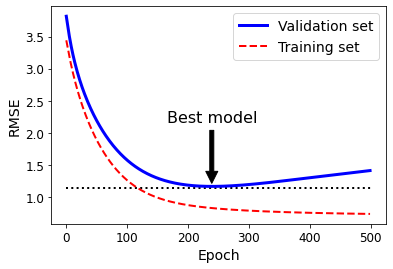

In [70]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [71]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# Logistic regression

We've been looking ad-nauseum at regression. Now that we know the foundations of how models get trained, let's see how this works for more interesting models, starting with binary logistic regression. 

## Review

Logistic Regression is commonly used to estimate the **probability that an instance belongs to a particular class**. 

Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result:


<img src="images_module04/20_logisitcfunc.png" width=600/>


The logistic noted σ(·) is a sigmoid function (i.e., S shaped) that outputs a number between 0 and 1:

<img src="images_module04/21_sigmoidfunc.png" width=600/>


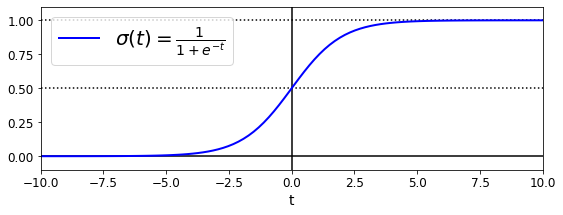

In [72]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Making predictions is simple:

<img src="images_module04/22_logit.png" width=600/>


Notice that: 
- σ(t) < 0.5 when t < 0
- σ(t) ≥ 0.5 when t ≥ 0

So a Logistic Regression model **predicts 1 if x⊺θ is positive and 0 if it is negative.** 

Why not just use regression that predicts 1s and 0s?
- https://thestatsgeek.com/2015/01/17/why-shouldnt-i-use-linear-regression-if-my-outcome-is-binary/
- https://jinglescode.github.io/datascience/2019/05/07/why-linear-regression-is-not-suitable-for-classification/
- https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression

## Training Logistic Regression from Scratch!

Now let's put what we've learned to practice, and write our own logistic regression model from scratch! Some additional refreshers below:

The objective of training is to set the parameter vector θ so that the model estimates:
- high probabilities for positive instances ( y = 1) 
- low probabilities for negative instances ( y = 0). 

Here is the cost function for a single instance:

<img src="images_module04/23_logloss.png" width=600/>


This cost function makes sense because **–log(p) grows very large when p approaches 0:** The cost will be large if the model estimates:
- a probability close to 0 for a positive instance
- a probability close to 1 for a negative instance




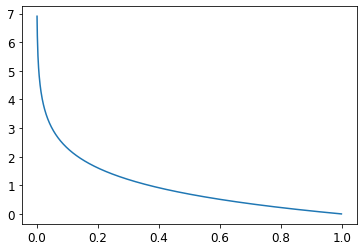

In [73]:
p = np.arange(0.001,1,0.001)
logp = -np.log(p)
plt.plot(p, logp)

The cost function over the whole training set is the average cost over all training instances:

<img src="images_module04/24_logloss.png" width=600/>


There is **no known closed-form equation to compute the value of θ that minimizes this cost function.** 

The good news is that this cost function is convex, so Gradient Descent is guaranteed to find the global minimum. 

The partial derivatives of the cost function with regard to the model parameter $\theta_j$ are given by 


<img src="images_module04/25_loglossgrad.png" width=600/>

For each instance:
- computes the prediction error,
- multiplies it by the j th feature value,
- then it computes the average over all training instances. 


Once you have the gradient vector containing all the partial derivatives, you can use it in the Gradient Descent algorithm. 

## From scratch!

Implementation from scratch:

- https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac

Derivation from scratch:

- https://towardsdatascience.com/gradient-descent-demystified-bc30b26e432a

In [74]:
# ?datasets.make_blobs

(1000, 4)
(1000,)


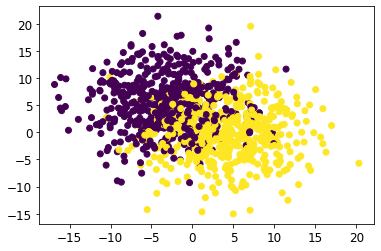

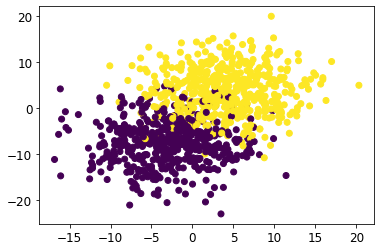

In [75]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=1000, n_features=4, centers=2, cluster_std=5)
print(X.shape)
print(y.shape)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()
plt.scatter(X[:,0], X[:,2], c=y)
plt.show()

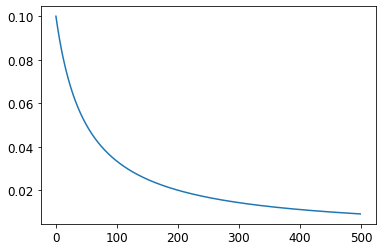

In [76]:
def learning_schedule(t, t0=5, t1=50):
    return t0 / (t + t1)

lrs = [learning_schedule(i) for i in range(500)]
plt.plot(range(500), lrs)
plt.show()

Iteration: 0	 Learning Rate: 0.1 	 Accuracy: 0.704
Training Complete! Ran for 3 epochs


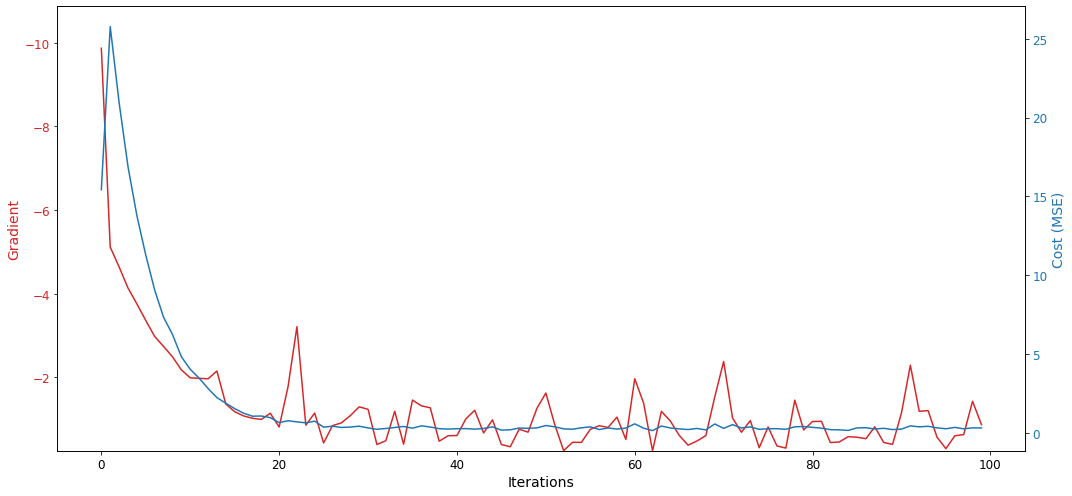

THETA:
 [[-0.12984593  0.12975681]
 [ 0.04585289 -0.04574007]
 [-0.12586854  0.12609061]
 [-0.01731555  0.01735089]]


In [91]:
from sklearn.metrics import accuracy_score, log_loss
import scipy
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def getProbsAndPreds(someX,someY):
    k= len(np.unique(someY))
    n = someX.shape[1]
    w= np.random.randn(n,k)
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

def getAccuracy(someX,someY):
    prob,prede = getProbsAndPreds(someX,someY)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy

def custom_logreg(X, y, eta=0.01, use_lrs=True, n_epochs=1000,  max_iter=100, minibatch_size=20):
    """Logistic regression using minibatch gradient descent. 

    Returns the feature weights (theta), magnitude of gradient for the bias, 
    magnitude of the gradient for the weights, and the value of the loss function 
    at each step. 

    """
    n = X.shape[1]
    m = X.shape[0]
    theta = np.random.randn(n,1)  # random initialization of feature weights
    thetas = []
    g_bias = [] # magnitude of gradient from bias term
    g_theta = [] # magnitude of gradient from feature weights
    losses = []
    t=0
    

    for epoch in range(n_epochs):
        # re-shuffle your training data for this epoch
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        # train on one mini-batch at a time
        for i in range(0, m, minibatch_size):

            # note: axis 0 is your training samples, axis 1 is the feature values
            xi = X_b_shuffled[i:i+minibatch_size,:]
            if xi.shape[0] < minibatch_size:
                # end epoch if remaining mini-batch is too small
                break

            yi = y_shuffled[i:i+minibatch_size]  #.reshape(minibatch_size,-1)
            y_mat = oneHotIt(yi)
            scores = np.dot(xi,theta) #Then we compute raw class scores given our input and current weights
            prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
            gradients = (-1 /minibatch_size) * np.dot(xi.T,(y_mat - prob)) + theta
            loss = (-1 / minibatch_size) * np.sum(y_mat * np.log(prob)) + np.sum(theta*theta) #We then find the loss of the probabilities
            #loss = (1 / minibatch_size) * np.sum(- np.log(prob[np.arange(minibatch_size), y]))

#             # compute the gradient
#             preds = sigmoid(xi.dot(theta))
#             error = (preds - yi)
#             gradients = 1/minibatch_size * np.dot(xi.T, (preds - yi))

#             # apply the update to your weights (theta)
            if use_lrs:
                eta = learning_schedule(t) # Calc lr
            theta = theta - eta * gradients # Update step

#             # compute loss function after the step
#             y_proba = sigmoid(X.dot(theta)) # Make Preds using sigmoid function
#             y_hat = y_proba > 0.5 # Make Preds using sigmoid function
#             loss = log_loss(y, y_proba) # Use accuracy instead of mse

            # append values
            thetas.append(theta)
            g_bias.append(gradients[0][0])
            g_theta.append(-np.linalg.norm(gradients))
            losses.append(loss)
            

            if len(g_bias)==max_iter:
                print(f"Training Complete! Ran for {t} epochs")
                return theta, thetas, g_bias, g_theta, losses
        t += 1 # Normally this would be done on every epoch, not iteration
        accuracy = getAccuracy(X,y)
        if epoch % 10 == 0: 
            print(f"Iteration: {t-1}\t Learning Rate: {eta} \t Accuracy: {accuracy}"   )

    print(f"Training Complete! Ran for {t-1} epochs")
    return theta, thetas, g_bias, g_theta, losses  

# Run Function
theta, thetas_mb, g_bias, g_theta, losses = custom_logreg(X, y, use_lrs=True, minibatch_size=32)

# Plot results
plot_gs(g_theta, losses)
print("THETA:\n", theta)


In [84]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)
print(log_reg.coef_)

preds = log_reg.predict(X)
accuracy_score(y, preds)

[[ 0.32437429 -0.22638763  0.49023046  0.24201037]]


0.945

In [85]:
50000**2

2500000000

In [86]:
from sklearn.linear_model import SGDClassifier
log_reg = SGDClassifier(random_state=42, loss='log')
log_reg.fit(X, y)
print(log_reg.coef_)

preds = log_reg.predict(X)
accuracy_score(y, preds)

[[ 2.3186553  -2.23590619  1.57864693 -0.01380024]]


0.902

## Decision Boundaries

The Iris datasert contains the **sepal and petal length and width of 150 iris flowers of three different species**:
- Iris setosa
- Iris versicolor
- Iris virginica 

Let’s try to build a classifier to detect the **Iris virginica** type based **only on the petal width feature**:

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

In [ ]:
print(iris.DESCR)

In [ ]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

print(X.shape)
print(y.shape)
y[0:10]

**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [ ]:
decision_boundary

Petal width ranges:
- Iris virginica: 1.4 cm to 2.5 cm,
- Not Iris Virginica: 0.1 cm to 1.8 cm. 

**Notice that there is a bit of overlap, this will give linear classifiers problems**

Above about 2 cm the classifier is highly confident that the flower is an Iris virginica, while below 1 cm it is highly confident that it is not an Iris virginica. In between these extremes, the classifier is unsure. 

There is a **decision boundary** at around 1.6 cm where both probabilities are equal to 50%.

In [ ]:
log_reg.predict([[1.7], [1.5]])

Let try this with two features, petal width and petal length.

Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have an over 90% chance of being Iris virginica, according to the model. 


In [ ]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

## Regularization

L1 and L2 regularization can be applied to a LogisticRegression model just as they are applied to a LinearRegression model.

However, the hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not `alpha` (as in other linear models), but its inverse `C`. **The higher the value of `C` , the less the model is regularized.**


In [89]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.01, random_state=42) #lotsa regularization
log_reg.fit(X, y)

LogisticRegression(C=0.01, random_state=42)

# Softmax Regression (Multi-Class Classification)

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers (OvO, OvR). **This is called Softmax Regression**, or Multinomial Logistic Regression. 

When given an instance $x$: 
- the model first computes a score $s_k(x)$ for each class $k$, 
- then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores. 

The equation looks similar to a linear regression, however **each class has its own dedicated parameter vector $\theta^{(k)}$**. Theses vectors are stored in parameter matrix $\Theta$

<img src="images_module04/26_softmax.png" width=300/>


FROM SCRATCH:
- https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html

In [88]:
m = 100
n = 5
k = 3

x = np.random.rand(m,n)
print("X shape:", x.shape)
Theta = np.random.rand(n, k)
print("Theta shape:", Theta.shape)
# Make predictions
preds = np.dot(x, Theta)
preds.shape

X shape: (100, 5)
Theta shape: (5, 3)


(100, 3)

Once you have computed the score of every class for the instance x, you can estimate the **probability $\hat{p}_k$ that the instance belongs to class k by running the scores through the softmax function**: 

The function computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials). 

<img src="images_module04/27_softmax2.png" width="600" />

$\sigma(s(x))_k$ is the estimated probability that the instance $x$ belongs to class $k$ , given the scores of each class for that instance. All probability scores **should sum to 1**.

The predicted class is simply the class with the highest score:

<img src="images_module04/28_softmax3.png" width="600" />

The Softmax Regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput), so it should be used only with mutually exclusive classes, such as different types of plants. 


In [90]:
def softmax(y_linear):
    exp = np.exp(y_linear)
    norms = np.sum(exp, axis=1).reshape(-1,1)
    return exp / norms
                 
out = softmax(preds)
print("Softmax output:", out.shape)
print("Class output:", np.argmax(out, axis=-1))
out[1]

Softmax output: (100, 3)
Class output: [1 1 0 1 2 0 2 2 1 1 1 2 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 2 2 0 1
 1 2 1 1 1 0 0 1 1 1 1 1 1 1 2 1 2 2 2 1 0 1 2 2 2 1 1 1 1 1 2 1 1 1 1 0 2
 0 1 1 1 2 1 2 1 2 1 1 1 2 2 1 1 0 1 1 1 1 2 1 1 1 1]


array([0.3326605 , 0.34917016, 0.31816935])

In [91]:
out

array([[0.27032259, 0.40698581, 0.3226916 ],
       [0.3326605 , 0.34917016, 0.31816935],
       [0.36963915, 0.35295508, 0.27740576],
       [0.30482019, 0.37538386, 0.31979595],
       [0.28596248, 0.30805789, 0.40597962],
       [0.38020962, 0.32997101, 0.28981938],
       [0.3341101 , 0.30467871, 0.36121119],
       [0.26154835, 0.3671512 , 0.37130045],
       [0.24921502, 0.39493145, 0.35585353],
       [0.24530778, 0.39271474, 0.36197749],
       [0.31560978, 0.45847313, 0.22591709],
       [0.2837986 , 0.31927214, 0.39692926],
       [0.24660413, 0.36459454, 0.38880133],
       [0.30518762, 0.37348187, 0.32133051],
       [0.33747704, 0.38175824, 0.28076472],
       [0.28531635, 0.42370169, 0.29098197],
       [0.24787262, 0.31944477, 0.43268262],
       [0.28299534, 0.36845742, 0.34854724],
       [0.29483436, 0.36596075, 0.3392049 ],
       [0.29196021, 0.35658151, 0.35145828],
       [0.24666194, 0.43157101, 0.32176705],
       [0.263807  , 0.44117789, 0.29501512],
       [0.

## Cross Entropy

The objective of the softmax function to have a model that estimates a **high probability for the target class (and consequently a low probability for the other classes)**: for this we use **Cross Entropy**. 

Minimizing the cross entropy penalizes the model when it estimates a low probability for a target class. 

<img src="images_module04/29_crossentropy.png" width="600" />

$y^{(i)}_k$ is the target probability that the $i^{th}$ instance belongs to class $k$. **In general**, it is either equal to 1 or 0.

**Note that when there are just two classes $( K = 2)$, this cost function is equivalent to the Logistic Regression’s cost function (log loss).**

For training, the gradient vector is defined as follows:

<img src="images_module04/30_crossentropygrad.png" width="600" />

Let’s use Softmax Regression to classify the iris flowers into all three classes. 

Scikit-Learn’s LogisticRegression uses **one-versus-the-rest by default when you train it on more than one class**. Set `multi_class` hyperparameter to "multinomial" to run a softmax regression model. 

You must also specify a solver that supports Softmax Regression, such as the **"lbfgs" solver** (see Scikit-Learn’s documentation for more details). It also applies ℓ2 regularization by default, which you can control using the hyperparameter C: 


In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [ ]:
softmax_reg.predict([[5, 2]])

In [ ]:
softmax_reg.predict_proba([[5, 2]])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [ ]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [ ]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

In [ ]:
to_one_hot(y_train[:10])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, **it's easy to mix up the order of the terms, or the indices.** 

You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should **write down the shape of each term in the equation and make sure the corresponding terms in your code match closely.** 

It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
X_train.shape

In [ ]:
np.unique(y_train)

In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.